## Download the data set (only when you don't have it)

In [ ]:
! wget -nv -O imagenet_val.tar.gz -L https://berkeley.box.com/shared/static/pouthcomrvxw9hj64oxhacjvqdw3ihlp.gz
! mkdir imagenet_val
! tar -xf imagenet_val.tar.gz -C ./imagenet_val/
! mv imagenet_val/scratch/group/ilsvrc/val/* imagenet_val/
! rm -r imagenet_val/scratch

2025-04-12 20:24:11 URL:https://public.boxcloud.com/d/1/b1!22Z_tXkAkg03UjItOyxmPksn3dh6LkpOPpSazWAuiWEk_UE0Qdjg34h7fpXT9_cBjcLMenyEGHcNL2t11CrWGA9xBr_eEfyHMqry4OhmAxLT9VNQvGb7_BwtNaKYDnkEhVo_H502kUOF7_QDWrFZKuC5Ya-PDaUfSkxZUZ9LGSRRtHXHDatO1QS53N_mkfeYzcLUKHtx7WQTk9PwcmUCLDamQTZZI3mv0c99ujb0TxRby4wYadg62Un-z40MPEDjXFmP9ko4KO0tPxS-_2K3y8j3yGyXT49bVq_fg5nXu4f0Os6jQiXt4zAL8oIeQ6BibKIGEir_DICw5DlWzCnkOBR8oLswJ6GCICso1CJf5pgxToef7-b75dDTZxHeFSB7Ehg-qShRYA1t4xwWHSBZOz_RrIUvCEMhTS-0jEtE_CAQ4_Y9TXuZHnx5w7tCR4jsfx9gJXNnLgBuww3ZueE_Gk8RrgmV_j_EL-waCpd2_yzTh5lHTIsYih45irS75ZbZ2B-iSE1Ac9sdi67Qrrse62Q5uCquX7naOpkGwmaub5nz_9pcbKZTwurYg0iYtCz9R4-3-QcFux8oCc0HnAiiRJN0oeLjLPQKhTwmsVLjOUqeIe2d6NxYugF1KTDb2ToolYDNgwRAWEZCuZ-lRgSOgI2-qdYtPEbKV9figIb2Rm8NsK77VsI97s0_ajMLZNZge4T6vq-EAHxCQY34rdWaslzvmSY0NbhBiJ4q63Nks4HZyBur_qgoxjm0jwilh0dkbYbQRicby88wFiATXfEUbGm3tqXCWPT6qa3H3i8V1rplZRn1QQrg08dfsd11DRnhCikUIGj4sQl0fFAuHv5GbSgS8bqNK9ecdInjBBpIY4uMHK6ndOd5vPeBTyrHDuEizaT5YI3T7Qe_2zJ1d-eoU_e0foAPN6s4A6e98l9cXYSgw

In [1]:
import torch
from torchvision import models, transforms
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
from torch.nn import functional as F
import numpy as np
import torchvision
import matplotlib.pyplot as plt
from torch import nn, optim
from scipy.special import softmax
import seaborn as sns
import pandas as pd

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


/home/nikhiljamuda/Desktop/RefineRAPS/venv/lib/python3.12/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


## Loading pretrained ResNet101 model

In [3]:
model = models.resnet152(pretrained=True,progress=True)
model.eval()
model = model.to(device)

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])


/home/nikhiljamuda/Desktop/RefineRAPS/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nikhiljamuda/Desktop/RefineRAPS/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Load the data set

In [4]:
num_calib = 5000

# Get the conformal calibration dataset
imagenet_calib_data, imagenet_val_data ,imagenet_param_data= torch.utils.data.random_split(torchvision.datasets.ImageFolder('./imagenet_val/', transform), [num_calib,50000-num_calib-1000,1000])
batch_size = 128

# Reduce the size of the validation set to 10000
imagenet_val_data = torch.utils.data.Subset(imagenet_val_data, range(10000))

# Initialize loaders
calib_loader = torch.utils.data.DataLoader(imagenet_calib_data, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader = torch.utils.data.DataLoader(imagenet_val_data, batch_size=batch_size, shuffle=True, pin_memory=True)
param_loader = torch.utils.data.DataLoader(imagenet_param_data, batch_size=batch_size, shuffle=True, pin_memory=True)

# Function for Conformal Prediction Procedures

In [5]:


def get_logits(model, dataloader, device):
    model.eval()
    logits_list, labels_list = [], []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            logits_list.append(outputs.cpu())
            labels_list.append(labels)
    return torch.cat(logits_list), torch.cat(labels_list)


def temperature_scaling(logits, labels, max_iters=50, lr=0.01, epsilon=1e-4):
    T = nn.Parameter(torch.tensor([1.3], requires_grad=True))
    optimizer = optim.SGD([T], lr=lr)
    criterion = nn.CrossEntropyLoss()

    for i in range(max_iters):
        optimizer.zero_grad()
        scaled_logits = logits / T
        loss = criterion(scaled_logits, labels)
        loss.backward()
        optimizer.step()
        if abs(loss.item()) < epsilon:
            break
    return T.detach()

def compute_scores(sorted_probs_list, sorted_indices_list, labels,
                   lambda_reg=0.1, k_reg=5, randomized=True, allow_zero_sets=True):
    scores = []
    for i in range(len(labels)):
        sorted_probs = sorted_probs_list[i]
        sorted_indices = sorted_indices_list[i]
        cumsum = np.cumsum(sorted_probs)

        penalties = np.zeros_like(sorted_probs)
        penalties[k_reg:] += lambda_reg
        penalties_cumsum = np.cumsum(penalties)

        target = labels[i].item()
        rank = np.where(sorted_indices == target)[0][0]

        if not randomized:
            tau = cumsum[rank] + penalties_cumsum[rank]
        else:
            U = np.random.rand()
            if rank == 0:
                tau = U * cumsum[0] + penalties_cumsum[0] if allow_zero_sets else cumsum[0] + penalties_cumsum[0]
            else:
                tau = U * sorted_probs[rank] + cumsum[rank - 1] + penalties_cumsum[rank]

        scores.append(tau)
    return np.array(scores)


def compute_threshold(scores, alpha):
    return np.quantile(scores, 1 - alpha, method="higher")

def predict_set(sorted_probs, sorted_indices, tau, lambda_reg=0.1, k_reg=5, randomized=True, allow_zero_sets=True):

    cumsum = np.cumsum(sorted_probs)

    penalties = np.zeros_like(sorted_probs)
    penalties[k_reg:] += lambda_reg
    penalties_cumsum = np.cumsum(penalties)

    sizes_base = (cumsum + penalties_cumsum <= tau).sum() + 1
    sizes_base = min(sizes_base, len(sorted_probs))

    if randomized and sizes_base < len(sorted_probs):
        V = 1 / sorted_probs[sizes_base - 1] * (
            tau - (cumsum[sizes_base - 1] - sorted_probs[sizes_base - 1]) - penalties_cumsum[sizes_base - 1]
        )
        sizes = sizes_base - int(np.random.rand() >= V)
    else:
        sizes = sizes_base

    if tau == 1.0:
        sizes = len(sorted_probs)

    if not allow_zero_sets and sizes == 0:
        sizes = 1

    sizes = max(sizes, 1)
    return sorted_indices[:sizes].tolist()

def platt_scaling(logits_data, T):
    logits_data = logits_data.cpu().numpy()
    sorted_probs = []
    sorted_indices =[]
    for i in range(len(logits_data)):
        scaled_logits = logits_data[i] / T.item()
        probs = softmax(scaled_logits)
        sorted_indices.append(np.argsort(probs)[::-1])
        sorted_probs.append(np.sort(probs)[::-1])

    return sorted_probs, sorted_indices

def optimal_k_reg(sorted_indices_list, labels, alpha):

    ranks = []
    for i in range(len(labels)):
        true_label = labels[i].item()
        rank = np.where(sorted_indices_list[i] == true_label)[0][0]
        ranks.append(rank)

    k_reg = compute_threshold(np.array(ranks), alpha=alpha)
    return k_reg

def naive_predict(sorted_probs, sorted_indices, tau, randomized=False):
    cum_sum = 0.0
    L = 0

    while L < len(sorted_probs) and cum_sum < tau:
        cum_sum += sorted_probs[L]
        L += 1

    # Break ties randomly as per Algorithm 1
    if randomized and L > 0:
        U = np.random.uniform(0, 1)
        score_sum = np.sum(sorted_probs[:L])
        V = (score_sum - tau) / sorted_probs[L - 1] if sorted_probs[L - 1] > 0 else 0
        if U <= V:
            L -= 1

    return sorted_indices[:L].tolist()


## Getting Logits

In [7]:

logits_calib, labels_calib = get_logits(model, calib_loader, device)
logits_test, labels_test = get_logits(model, test_loader, device)

T = temperature_scaling(logits_calib, labels_calib)

sorted_probs_calib, sorted_indices_calib = platt_scaling(logits_calib, T)
sorted_probs_test, sorted_indices_test = platt_scaling(logits_test, T)

param_logits, param_labels = get_logits(model, param_loader, device)
sorted_probs_param, sorted_indices_param = platt_scaling(param_logits, T)

## Computing over values of alphas

In [8]:
alphas =  [0.01, 0.05, 0.1]

average_sizes = {'RAPS': [], 'APS': [], 'Naive': []}
average_coverages = {'RAPS': [], 'APS': [], 'Naive': []}

# Hyperparameters
lambda_reg = 0.01
k_reg = 5
randomized = True
allow_zero_sets = True
allow_optimal_k = True

for alpha in alphas:

    # Optimal k_reg
    k_reg = optimal_k_reg(sorted_indices_param, param_labels, alpha=alpha) if allow_optimal_k else k_reg
    print(f"Optimal k_reg for alpha {alpha}: {k_reg}")


    ########-------------RAPS------------#########
    scores = compute_scores(sorted_probs_calib, sorted_indices_calib, labels_calib,lambda_reg=lambda_reg,
                             k_reg=k_reg, randomized=randomized, allow_zero_sets=allow_zero_sets)

    tau = compute_threshold(scores, alpha=alpha)


    prediction_sets = [
        predict_set(sorted_probs_test[i], sorted_indices_test[i], tau,lambda_reg=lambda_reg,
                    k_reg=k_reg,randomized=randomized, allow_zero_sets=allow_zero_sets)
        for i in range(len(sorted_probs_test))
    ]

    sizes = [len(pset) for pset in prediction_sets]
    coverage = np.mean([
        labels_test[i].item() in prediction_sets[i] for i in range(len(labels_test))
    ])

    average_sizes['RAPS'].append(np.mean(sizes))
    average_coverages['RAPS'].append(coverage)

    ###########-----APS(RAPS with lambda=0)---#######

    scores_aps = compute_scores(sorted_probs_calib, sorted_indices_calib, labels_calib,lambda_reg=0,
                             k_reg=0, randomized=randomized, allow_zero_sets=allow_zero_sets)

    tau_aps = compute_threshold(scores_aps, alpha=alpha)


    prediction_sets_aps = [
        predict_set(sorted_probs_test[i], sorted_indices_test[i], tau_aps,lambda_reg=0,
                    k_reg=0,randomized=randomized, allow_zero_sets=allow_zero_sets)
        for i in range(len(sorted_probs_test))
    ]

    sizes_aps = [len(pset) for pset in prediction_sets_aps]
    coverage_aps = np.mean([ labels_test[i].item() in prediction_sets_aps[i] for i in range(len(labels_test))])

    average_sizes['APS'].append(np.mean(sizes_aps))
    average_coverages['APS'].append(coverage_aps)

    ########---Naive ---#######
    tau = 1 - alpha

    prediction_sets_naive = [
        naive_predict(sorted_probs_test[i], sorted_indices_test[i], tau, randomized=randomized)
        for i in range(len(sorted_probs_test))
    ]

    sizes_naive = [len(pset) for pset in prediction_sets_naive]
    coverage_naive = np.mean([labels_test[i].item() in prediction_sets_naive[i] for i in range(len(labels_test))])

    average_sizes['Naive'].append(np.mean(sizes_naive))
    average_coverages['Naive'].append(coverage_naive)





Optimal k_reg for alpha 0.01: 50
Optimal k_reg for alpha 0.05: 8
Optimal k_reg for alpha 0.1: 3


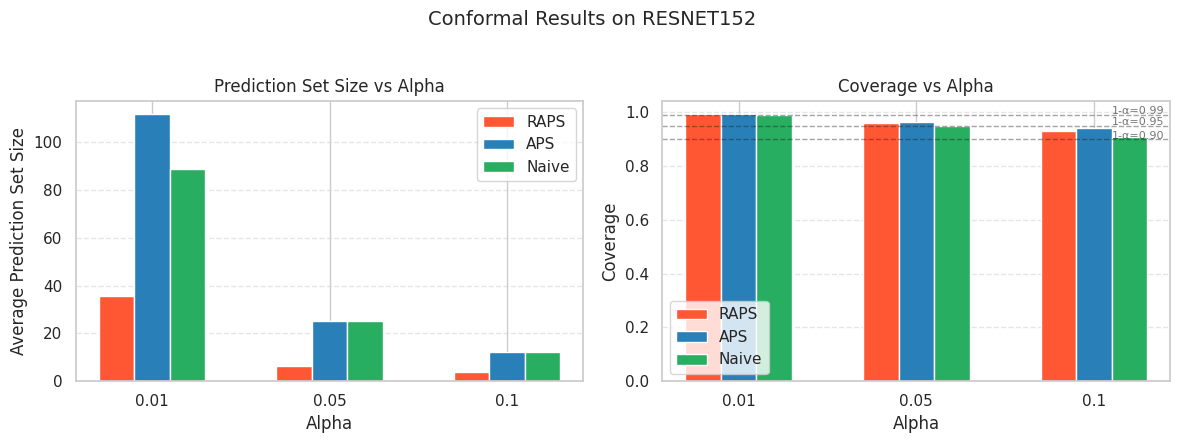

In [9]:
# print("-" * len(header))
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="whitegrid")

methods = ['RAPS', 'APS', 'Naive']
colors = ['#FF5733', '#2980B9', '#27AE60']  # RAPS, APS, Naive
x = np.arange(len(alphas))
bar_width = 0.2  # thinner bars
spacing = bar_width * len(methods) + 0.05  # space between groups

# ---- Plot Side-by-Side ---- #
fig, axs = plt.subplots(1, 2, figsize=(12, 4.5))  # slightly wider figure

# --- Prediction Set Size --- #
for i, method in enumerate(methods):
    axs[0].bar(x + i * bar_width, average_sizes[method], width=bar_width, label=method, color=colors[i])

axs[0].set_xticks(x + (len(methods) - 1) * bar_width / 2)
axs[0].set_xticklabels(alphas)
axs[0].set_xlabel('Alpha')
axs[0].set_ylabel('Average Prediction Set Size')
axs[0].set_title('Prediction Set Size vs Alpha')
axs[0].legend()
axs[0].grid(axis='y', linestyle='--', alpha=0.5)

# --- Coverage Plot --- #
for i, method in enumerate(methods):
    axs[1].bar(x + i * bar_width, average_coverages[method], width=bar_width, label=method, color=colors[i])

for i, alpha in enumerate(alphas):
    y = 1 - alpha
    axs[1].axhline(y=y, color='k', linestyle='--', linewidth=1, alpha=0.4)
    axs[1].text(len(alphas) - 0.7, y + 0.002, f'1-α={y:.2f}', color='k', fontsize=8, alpha=0.6)

axs[1].set_xticks(x + (len(methods) - 1) * bar_width / 2)
axs[1].set_xticklabels(alphas)
axs[1].set_xlabel('Alpha')
axs[1].set_ylabel('Coverage')
axs[1].set_title('Coverage vs Alpha')
axs[1].legend()
axs[1].grid(axis='y', linestyle='--', alpha=0.5)

plt.suptitle(f"Conformal Results on {'ResNet152'.upper()}", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(f"conformal_summary_{'ResNet152'.lower()}_optimal.png", dpi=300)
plt.show()


In [10]:
methods = ['RAPS', 'APS', 'Naive']

# Header
header = f"{'Alpha':<10}"
for method in methods:
    header += f"{method + ' Size':>15}{method + ' Coverage':>20}"
print("\n" + "-" * len(header))
print(header)
print("-" * len(header))

# Rows
for i, alpha in enumerate(alphas):
    row = f"{alpha:<10.2f}"
    for method in methods:
        size = average_sizes[method][i] if method in average_sizes else float('nan')
        cov = average_coverages[method][i] if method in average_coverages else float('nan')
        row += f"{size:>15.3f}{cov:>20.3f}"
    print(row)

print("-" * len(header))


-------------------------------------------------------------------------------------------------------------------
Alpha           RAPS Size       RAPS Coverage       APS Size        APS Coverage     Naive Size      Naive Coverage
-------------------------------------------------------------------------------------------------------------------
0.01               35.825               0.991        111.631               0.992         88.850               0.989
0.05                6.324               0.958         25.331               0.963         25.290               0.950
0.10                3.993               0.930         12.188               0.940         12.266               0.907
-------------------------------------------------------------------------------------------------------------------
